## Here we will try our best shot to predict the goals with our features

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main

/content/gdrive/MyDrive/Master_UdeM/IFT-6758/Project/ift6758-project-main


In [3]:
#!git clone https://GIT_TOKEN@github.com/M0rph3e/ift6758-project-main.git #not anymore
! git pull

remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 9), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (12/12), done.
From https://github.com/M0rph3e/ift6758-project-main
   5ed5e8a..b1aee36  best_shot_trial -> origin/best_shot_trial
   5e9c863..7da13ab  fengineering1   -> origin/fengineering1
Already up to date.


In [4]:
!git status

On branch fengineering2
Your branch is up to date with 'origin/fengineering2'.

nothing to commit, working tree clean


In [ ]:
!pip install comet_ml pandas_profiling

In [6]:
! git branch

  best_shot_trial
* fengineering2
  main


# Real **** starts from here

In [7]:
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.data.data_acquisition import Season
from ift6758.visualizations.simple_visualization import Utilities 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import pandas as pd
import pickle
import sys
import json

import warnings
warnings.filterwarnings("ignore")

In [8]:
train_years = [2015,2016,2017]
valid_years = [2018]
test_years=[2019]


train_dataset = SeasonDataSetTwo(train_years)
valid_dataset = SeasonDataSetTwo(valid_years)
train_df = train_dataset.get_features_2()
valid_df = valid_dataset.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2015_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2015_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2016_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2016_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2017_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2017_period_info.pkl
File with all events already Exists, loading from ../ift6758/data/PICKLE//2018_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2018_period_info.pkl


In [9]:
test_data = SeasonDataSetTwo(test_years)
test_df = test_data.get_features_2()

File with all events already Exists, loading from ../ift6758/data/PICKLE//2019_clean_all_events.pkl
File already Exists, loading from ../ift6758/data/PICKLE//2019_period_info.pkl


# Export the data csv to comet (do not execute for now)

In [ ]:
from comet_ml import Experiment
import os



exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name='milestone-2',
    workspace='morph-e',
)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/2689d4e3e26d42a88824134ac2b782bd
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fbest_shot_trial%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : 1
COMET INFO:     copy                     : True
COMET INFO:     criterion                : entropy
COMET INFO:     max_depth                : 10
COMET INFO:     max_features             : auto
COMET INFO:     max_leaf_nodes           : 1
COMET INFO:     max_samples              : 1
COMET INFO:     min_impurity_d

In [ ]:
experiment.log_dataframe_profile(
train_df, 
name='train_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

experiment.log_dataframe_profile(
valid_df, 
name='valid_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)

experiment.log_dataframe_profile(
test_df, 
name='test_set_from_FE2',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring
COMET WARNING: unable to profile dataframe; ignoring


{'dataframe': {'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=4e8eecdee4cf45708b03fb750b84e180&experimentKey=2689d4e3e26d42a88824134ac2b782bd',
  'assetId': '4e8eecdee4cf45708b03fb750b84e180',
  'web': 'https://www.comet.ml/api/asset/download?assetId=4e8eecdee4cf45708b03fb750b84e180&experimentKey=2689d4e3e26d42a88824134ac2b782bd'},
 'profile': None}

In [ ]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/efb5cd930b034742b57308a8f96d6217
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fbest_shot_trial%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Uploads:
COMET INFO:     dataframe           : 6 (169.17 MB)
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program terminatio

# Split and shuffle Data

In [ ]:
random.seed(42)

In [47]:
train_df = train_df.sample(frac=1)
test_df = test_df.sample(frac=1)
valid_df = valid_df.sample(frac=1)

In [48]:
train_df.head()

,result.penaltySeverity,result.penaltyMinutes,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,result.strength.name,gameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle
167247,NaN,NaN,2017020117,Columbus Blue Jackets,2,-48.0,-25.0,Snap Shot,0,NaN,826.0,48.020829,-31.373005,0,Blocked Shot,63.0,14.0,21.0,117.652029,False,5.602478,0.00000
186488,NaN,NaN,2017020418,Montréal Canadiens,2,75.0,-27.0,Wrist Shot,0,NaN,49.0,30.413813,62.592425,0,Hit,77.0,39.0,11.0,66.030296,False,6.002754,0.00000
151919,NaN,NaN,2016021192,Buffalo Sabres,1,42.0,-9.0,Wrist Shot,0,NaN,784.0,47.853944,10.840305,0,Shot,58.0,-18.0,6.0,18.357560,True,3.059593,19.30108
242899,NaN,NaN,2017030143,Philadelphia Flyers,3,19.0,-33.0,Wrist Shot,0,NaN,669.0,112.929181,-16.990823,0,Faceoff,-20.0,22.0,7.0,67.424031,False,9.632004,0.00000
97360,NaN,NaN,2016020300,Carolina Hurricanes,1,32.0,-33.0,Wrist Shot,0,NaN,684.0,65.863495,30.068583,0,Hit,73.0,-39.0,5.0,41.436699,False,8.287340,0.00000


In [49]:
features = ['gameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle', 'shotDistance','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [50]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
dtype: bool

### Replace inf with nan (annoying in normalization)

In [51]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
valid_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [52]:
#drop rows with nan
train_df = train_df[train_df['shotType'].notna()]
valid_df = train_df[train_df['shotType'].notna()]
test_df = train_df[train_df['shotType'].notna()]

train_df = train_df[train_df['shotAngle'].notna()]
valid_df = train_df[train_df['shotAngle'].notna()]
test_df = train_df[train_df['shotAngle'].notna()]

train_df = train_df[train_df['shotDistance'].notna()]
valid_df = train_df[train_df['shotDistance'].notna()]
test_df = train_df[train_df['shotDistance'].notna()]

train_df = train_df[train_df['speed'].notna()]
valid_df = train_df[train_df['speed'].notna()]
test_df = train_df[train_df['speed'].notna()]

train_df = train_df[train_df['changeInShotAngle'].notna()]
valid_df = train_df[train_df['changeInShotAngle'].notna()]
test_df = train_df[train_df['changeInShotAngle'].notna()]

In [53]:
train_df[features].isna().any()
valid_df[features].isna().any()
valid_df[features].isna().any()

gameSeconds              False
timeFromLastEvent        False
gamePeriod               False
shotType                 False
shotAngle                False
shotDistance             False
distanceFromLastEvent    False
rebound                  False
speed                    False
changeInShotAngle        False
dtype: bool

In [54]:
X_train = train_df[features]
y_train = train_df[label]

X_valid = valid_df[features]
y_valid = valid_df[label]

X_test = test_df[features]
y_test = test_df[label]

X_train, y_train, X_valid, y_valid

(        gameSeconds  timeFromLastEvent  ...     speed changeInShotAngle
 167247        826.0               21.0  ...  5.602478          0.000000
 186488         49.0               11.0  ...  6.002754          0.000000
 151919        784.0                6.0  ...  3.059593         19.301080
 242899        669.0                7.0  ...  9.632004          0.000000
 97360         684.0                5.0  ...  8.287340          0.000000
 ...             ...                ...  ...       ...               ...
 86546          98.0                7.0  ...  5.613395         13.337549
 35319         662.0                5.0  ...  1.216553          0.000000
 233126         59.0               13.0  ...  2.530290         91.494334
 137829        931.0                9.0  ...  6.996472          0.000000
 102797        270.0               23.0  ...  1.499212          0.000000
 
 [238046 rows x 10 columns],         isGoal
 167247       0
 186488       0
 151919       0
 242899       0
 97360        

### One Hot encode the shot type (I want to refer on the fact that the shot type affect the goal)

In [55]:
def one_hot(self, y):
        """Return a one hot encoded array of the labels
        """
        return np.eye(len(self.classes))[np.vectorize(lambda c: self.class_labels[c])(y).reshape(-1)]


In [56]:
dum_train = pd.get_dummies(X_train['shotType'], prefix='Shot',dtype=int)
dum_valid = pd.get_dummies(X_valid['shotType'], prefix='Shot',dtype=int)
dum_test = pd.get_dummies(X_test['shotType'], prefix='Shot',dtype=int)

In [57]:
X_train = pd.concat([X_train, dum_train], axis=1)
X_valid = pd.concat([X_valid, dum_valid], axis=1)
X_test = pd.concat([X_test, dum_test], axis=1)

In [58]:
#check if no nans
X_train.isna().any(), X_valid.isna().any(), X_test.isna().any()

(gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           False
 Shot_Tip-In              False
 Shot_Wrap-around         False
 Shot_Wrist Shot          False
 dtype: bool, gameSeconds              False
 timeFromLastEvent        False
 gamePeriod               False
 shotType                 False
 shotAngle                False
 shotDistance             False
 distanceFromLastEvent    False
 rebound                  False
 speed                    False
 changeInShotAngle        False
 Shot_Backhand            False
 Shot_Deflected           False
 Shot_Slap Shot           False
 Shot_Snap Shot           F

In [59]:
X_train = X_train.drop(columns='shotType')
X_valid = X_valid.drop(columns='shotType')
X_test = X_test.drop(columns='shotType')

# Change rebound feature

In [60]:
X_train['rebound'] = X_train['rebound'].astype(int)
X_valid['rebound'] = X_valid['rebound'].astype(int)
X_test['rebound'] = X_test['rebound'].astype(int)

In [61]:
X_test.head()

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
167247,826.0,21.0,2,-31.373005,48.020829,117.652029,0,5.602478,0.00000,0,0,0,1,0,0,0
186488,49.0,11.0,2,62.592425,30.413813,66.030296,0,6.002754,0.00000,0,0,0,0,0,0,1
151919,784.0,6.0,1,10.840305,47.853944,18.357560,1,3.059593,19.30108,0,0,0,0,0,0,1
242899,669.0,7.0,3,-16.990823,112.929181,67.424031,0,9.632004,0.00000,0,0,0,0,0,0,1
97360,684.0,5.0,1,30.068583,65.863495,41.436699,0,8.287340,0.00000,0,0,0,0,0,0,1


# Normalize numerical data 

In [62]:
num = ['gameSeconds','timeFromLastEvent','gamePeriod', 'shotAngle', 'shotDistance','distanceFromLastEvent','speed','changeInShotAngle']

In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[num])

X_train[num] = scaler.transform(X_train[num])
X_valid[num] = scaler.transform(X_valid[num])
X_test[num] = scaler.transform(X_test[num])

In [64]:
X_test

,gameSeconds,timeFromLastEvent,gamePeriod,shotAngle,shotDistance,distanceFromLastEvent,rebound,speed,changeInShotAngle,Shot_Backhand,Shot_Deflected,Shot_Slap Shot,Shot_Snap Shot,Shot_Tip-In,Shot_Wrap-around,Shot_Wrist Shot
167247,0.665419,0.369064,-0.037123,-0.884090,0.250906,1.205234,0,-0.236933,-0.363797,0,0,0,1,0,0,0
186488,-1.566108,-0.307472,-0.037123,1.691732,-0.302719,0.086404,0,-0.197229,-0.363797,0,0,0,0,0,0,1
151919,0.544796,-0.645739,-1.220910,0.273080,0.245659,-0.946836,1,-0.489168,0.573522,0,0,0,0,0,0,1
242899,0.214519,-0.578086,1.146664,-0.489839,2.291846,0.116612,0,0.162766,-0.363797,0,0,0,0,0,0,1
97360,0.257598,-0.713393,-1.220910,0.800174,0.811940,-0.446628,0,0.029386,-0.363797,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86546,-1.425381,-0.578086,-0.037123,0.866035,-0.849061,-0.493073,1,-0.235850,0.283915,1,0,0,0,0,0,0
35319,0.194415,-0.713393,-0.037123,0.573551,-0.751049,-1.212875,0,-0.671985,-0.363797,0,0,0,0,0,0,1
233126,-1.537388,-0.172165,1.146664,0.899448,-1.032291,-0.631784,1,-0.541671,4.079445,0,0,0,0,1,0,0
137829,0.966977,-0.442779,-1.220910,0.297335,0.442983,0.020039,0,-0.098659,-0.363797,0,0,0,0,0,0,1


# Try Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators':[50,65,80,100,115,130,150],
     'max_depth': [5,6,7,8,9,10,11,12,13,14]
}

rf = RandomForestClassifier(criterion='entropy')
sh = HalvingGridSearchCV(rf,param_grid, cv=4)
model = sh.fit(X_train,y_train)

In [66]:
model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=14, n_estimators=65)

In [67]:
y_pred_valid  = model.predict(X_valid)

In [68]:
y_proba_val = model.predict_proba(X_valid)[:,1] # get the proba of having a goal (pred=1)

In [73]:
score_ = model.score(X_valid,y_valid)
score_

0.9135965317627686

# Export model on comet before plotting

In [70]:
weights_dir = "../ift6758/models/weights"
experiment = "Random-forest-with-FE2"
predscore_val_dict={}

In [ ]:
!ls ..

ift6758  ift6758-project-main


In [71]:
import joblib

predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['true_valid_label']=y_valid
predscore_val_dict[experiment]['proba']=y_proba_val
predscore_val_dict[experiment]['prediction']=y_pred_valid

## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(model,filename)

['../ift6758/models/weights/Random-forest-with-FE2.pkl']

In [ ]:
exp.log_model("Random Forest", "../ift6758/models/weights/Random-forest-with-FE2.pkl")

{'api': 'https://www.comet.ml/api/rest/v2/experiment/asset/get-asset?assetId=c67d522e79cd4e61a3ead5de12207be8&experimentKey=61ab29d2969f46b3b444cf6aef7b24e6',
 'assetId': 'c67d522e79cd4e61a3ead5de12207be8',
 'web': 'https://www.comet.ml/api/asset/download?assetId=c67d522e79cd4e61a3ead5de12207be8&experimentKey=61ab29d2969f46b3b444cf6aef7b24e6'}

In [ ]:
exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/61ab29d2969f46b3b444cf6aef7b24e6
COMET INFO:   Others:
COMET INFO:     notebook_url : https://colab.research.google.com/notebook#fileId=https%3A%2F%2Fgithub.com%2FM0rph3e%2Fift6758-project-main%2Fblob%2Fbest_shot_trial%2Fnotebooks%2Ftry_your_best_shot.ipynb
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     installed packages  : 1
COMET INFO:     model-element       : 1 (9.11 MB)
COMET INFO:     notebook            : 1
COMET INFO:     os packages         : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading 1 metrics, params and output messages


# Plotting

In [38]:
# First we will switch branch, the plotting metrics are on main
!git checkout main

Switched to branch 'main'
Your branch is up to date with 'origin/main'.


In [74]:
!git branch

  best_shot_trial
  fengineering2
* main


In [75]:
!git pull

Already up to date.


              precision    recall  f1-score   support

           0       0.91      1.00      0.95    216808
           1       1.00      0.03      0.06     21238

    accuracy                           0.91    238046
   macro avg       0.96      0.52      0.51    238046
weighted avg       0.92      0.91      0.88    238046



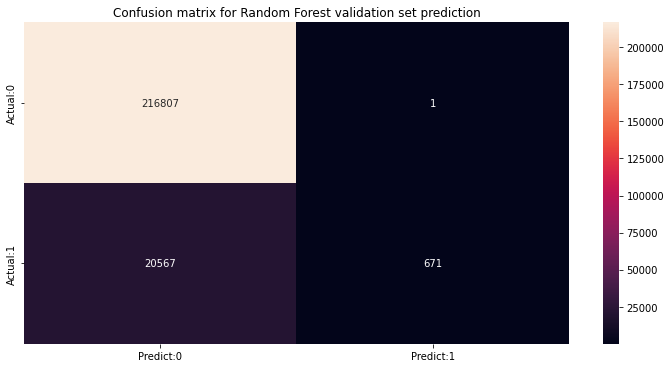

In [77]:
from ift6758.metrics import plot_metrics

plot_metrics.plotConfusion(y_valid,y_pred_valid, title='Confusion matrix for Random Forest validation set prediction')

In [79]:
plot_metrics.plot_roc(y_valid,score_)

AssertionError: ignored